In [1]:
import os
from scripts.MicroBrix import MicroBrix
import geopandas as gpd
import json

In [2]:
from numpy import mean
import random

In [4]:
gpd.read_file('data/output/land_uses_diversity')

,hex_id,diversity,geometry
0,69.0,0.0,"POLYGON ((671699.651 5922841.174, 671701.445 5..."
1,70.0,0.0,"POLYGON ((671721.911 5922796.403, 671723.705 5..."
2,71.0,0.0,"POLYGON ((671744.171 5922751.631, 671745.965 5..."
3,136.0,0.0,"POLYGON ((671749.554 5922838.066, 671751.348 5..."
4,137.0,0.0,"POLYGON ((671771.814 5922793.295, 671773.609 5..."
...,...,...,...
1917,2038.0,0.0,"POLYGON ((674037.255 5920960.189, 674039.049 5..."
1918,2039.0,0.0,"POLYGON ((674059.515 5920915.417, 674061.310 5..."
1919,2040.0,0.0,"POLYGON ((674081.775 5920870.646, 674083.570 5..."
1920,2041.0,0.0,"POLYGON ((674104.036 5920825.874, 674105.830 5..."


In [3]:
def indicator(geogrid, geogrid_data):
    layers = []

    #HEATMAP
    features = []
    for cell in geogrid['features']:
        feature = {}
        lat,lon = zip(*cell['geometry']['coordinates'][0])
        lat,lon = mean(lat),mean(lon)
        feature['coordinates'] = [lat,lon]
        feature['weight'] = random.random()*10
        features.append(feature)

    layers.append({"id":"heatmapN1","type":"heatmap","data":features,"properties":{"colorRange":[[237,248,251],[204,236,230],[153,216,201],[102,194,164],[44,162,95],[0,109,44]]}})

    #HEATMAP
    features = []
    for cell in geogrid['features']:
        feature = {}
        lat,lon = zip(*cell['geometry']['coordinates'][0])
        lat,lon = mean(lat),mean(lon)
        feature['coordinates'] = [lat,lon]
        feature['weight'] = random.random()*10
        features.append(feature)

    layers.append({"id":"heatmapN2","type":"heatmap","data":features,"properties":{}})

    point_a = random.choice(geogrid['features'])
    point_b = random.choice(geogrid['features'])
    lat_a,lon_a = zip(*point_a['geometry']['coordinates'][0])
    lat_a,lon_a = mean(lat_a),mean(lon_a)
    lat_b,lon_b = zip(*point_b['geometry']['coordinates'][0])
    lat_b,lon_b = mean(lat_b),mean(lon_b)

    #ARC
    arc_data = [{
        'inbound': 72633,
        'outbound': 74735,
        'from': {
            'name': 'Point A',
            'coordinates': [lat_a,lon_a]
        },
        'to': {
            'name': 'Point B',
            'coordinates': [lat_b,lon_b]
        }
    }]

    layers.append({"id": "arcN1", "type":"arc", "data":arc_data,"properties":{"width":2}})

    # Numeric indicators
    numeric = []

    numeric.append({"viz_type": "bar", "name": "example1", "value": random.random(), "description": "An example"})
    numeric.append({"viz_type": "bar", "name": "example2", "value": random.random(), "description": "An example 2"})
    numeric.append({"viz_type": "bar", "name": "example3", "value": random.random(), "description": "An example 3"})
    numeric.append({"viz_type": "bar", "name": "example4", "value": random.random(), "description": "An example 4"})

    numeric.append({"viz_type": "radar", "name": "exampleRadar1", "value": random.random(), "description": "An example"})
    numeric.append({"viz_type": "radar", "name": "exampleRadar2", "value": random.random(), "description": "An example 2"})
    numeric.append({"viz_type": "radar", "name": "exampleRadar3", "value": random.random(), "description": "An example 3"})
    numeric.append({"viz_type": "radar", "name": "exampleRadar4", "value": random.random(), "description": "An example 4"})

    return layers, numeric

In [4]:
def read_land_uses():
    from shapely.geometry import Polygon
    data = gpd.read_parquet('/app/data/landuses_actual.parquet')

    # Convertir la proyección a EPSG:4326
    gdf = data.to_crs(epsg=4326)

    # Verificar si el GeoDataFrame tiene geometría
    if 'geometry' not in gdf.columns:
        raise ValueError("El GeoDataFrame debe contener una columna 'geometry' con la geometría de los polígonos.")


    # Convertir los polígonos a coordenadas (x, y)
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: Polygon([(x, y) for x, y, _ in geom.exterior.coords]))
        
    features = json.loads(gdf.to_json())
    return features

def polygon_indicator(geogrid, geogrid_data):
    layers = []
    numeric = []
    features = read_land_uses()
    print(features)
    layers.append({"id": "land_uses", "type":"geojson", "data": features,"properties":{"filled": True, "color": [255, 0 ,0]}})
    return layers, numeric

In [5]:
def read_data():
    from shapely.geometry import Polygon
    data = gpd.read_file('/app/data/output/land_uses_diversity')

    # Convertir la proyección a EPSG:4326
    gdf = data.to_crs(epsg=4326)

    # Verificar si el GeoDataFrame tiene geometría
    if 'geometry' not in gdf.columns:
        raise ValueError("El GeoDataFrame debe contener una columna 'geometry' con la geometría de los polígonos.")

    # Convertir los polígonos a coordenadas (x, y)
    import numpy as np
    import matplotlib.pyplot as plt

    # Normalizar los valores de la columna 'diversity' entre 0 y 1
    norm = plt.Normalize(vmin=gdf['diversity'].min(), vmax=gdf['diversity'].max())

    # Crear el colormap JET
    colormap = plt.cm.jet

    # Aplicar el colormap para obtener los valores RGB
    gdf['color'] = gdf['diversity'].apply(lambda x: colormap(norm(x))[:3])  # Solo tomar RGB

    # Convertir a formato (R, G, B) con valores de 0 a 255 (opcional)
    gdf['color'] = gdf['color'].apply(lambda rgb: tuple(int(c * 255) for c in rgb))
    # gdf['color'] = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(len(gdf))]
    # convert fill to hex
    gdf['fill'] = gdf['color'].apply(lambda x: '#%02x%02x%02x' % (x[0], x[1], x[2]))
        
    features = json.loads(gdf.to_json())
    print(features)
    return features

def polygon_indicator(geogrid, geogrid_data):
    layers = []
    numeric = []
    features = read_data()
    layers.append({"id": "land_uses", "type":"geojson", "data": features, "properties":{"filled": True}})
    return layers, numeric

In [1]:
connection = MicroBrix(
    table_name='costanera_conce',
    module_function=polygon_indicator,
    keep_updating=False,
    quietly=True
    )
# connection.listen()

NameError: name 'MicroBrix' is not defined

In [7]:
connection.listen()

## Opened connection
{'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {'hex_id': 69.0, 'diversity': 0.0, 'color': [0, 0, 127], 'fill': '#00007f'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-73.07478456008639, -36.824730741371816], [-73.07477095680514, -36.8244708339957], [-73.07448417383867, -36.82435035090723], [-73.07421099312562, -36.82448977454459], [-73.0742245945093, -36.82474968192918], [-73.0745113785036, -36.82487016566794], [-73.07478456008639, -36.824730741371816]]]}}, {'id': '1', 'type': 'Feature', 'properties': {'hex_id': 70.0, 'diversity': 0.0, 'color': [0, 0, 127], 'fill': '#00007f'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-73.0745249809151, -36.82513007303383], [-73.0745113785036, -36.82487016566794], [-73.0742245945093, -36.82474968192918], [-73.07395141189869, -36.82488910490603], [-73.07396501241257, -36.825149012280406], [-73.0742517974347, -36.825269496669456], [-73.0745249809151, -36.82513007303383]]]}}, {'

In [8]:
connection.stop()

: 

<Axes: >

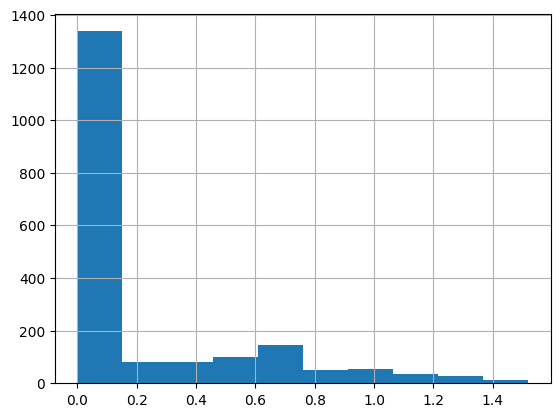

In [32]:
data = gpd.read_file('/app/data/output/land_uses_diversity')

# Convertir la proyección a EPSG:4326
gdf = data.to_crs(epsg=4326)

gdf['diversity'].hist()